In [ ]:
!pip3 install kaggle

In [9]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY'] = 'your_kaggle_API_key'

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
!unzip gtsrb-german-traffic-sign.zip

In [22]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm


In [23]:
class GTSRBDataset(datasets.ImageFolder):
    def __init__(self, csv_file, img_dir, transform=None):
        self.csv_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = {int(row['ClassId']): row['Path'].split('/')[0] for _, row in self.csv_data.iterrows()}

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.csv_data.iloc[index]['Path'])
        image = datasets.folder.default_loader(img_path)
        label = int(self.csv_data.iloc[index]['ClassId'])

        if self.transform:
            image = self.transform(image)

        return image, label

# Defined transformations
transformations = transforms.Compose([
    transforms.Resize((299, 299)), # InceptionV3 expects 299x299
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

base_dir = ''  # Adjust this path as necessary
train_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Train.csv'), img_dir=base_dir, transform=transformations)
test_data = GTSRBDataset(csv_file=os.path.join(base_dir, 'Test.csv'), img_dir=base_dir, transform=transformations)

# train val split
train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_data, [train_size, valid_size])

# Dataloaders for train val test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


In [24]:
# Loading pretrained Inception V3 model
model = models.inception_v3(pretrained=True)
# Freeze parameters
for param in model.parameters():
    param.requires_grad = False
# Replace the last layer with 43 classes in GTSRB
model.fc = nn.Linear(model.fc.in_features, 43)

if torch.cuda.is_available():
    model = model.cuda()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    pbar = tqdm(loader, desc="Training", unit="batch")
    for inputs, labels in pbar:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Handling aux logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())
    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    pbar = tqdm(loader, desc="Validating", unit="batch")
    with torch.no_grad():
        for inputs, labels in loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix(loss=loss.item())
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader), f1, accuracy

def test_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = running_loss / len(loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    return test_loss, f1, accuracy


In [26]:
# Training the model
num_epochs = 10
train_losses, valid_losses, valid_f1s, valid_accuracies = [], [], [], []
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    valid_loss, f1, accuracy = validate(model, valid_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_f1s.append(f1)
    valid_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}')



Validating:   0%|          | 0/62 [00:58<?, ?batch/s, loss=1.62]


Epoch 1, Train Loss: 1.9988, Valid Loss: 1.2860, F1: 0.6572, Accuracy: 0.6760


Validating:   0%|          | 0/62 [00:57<?, ?batch/s, loss=1.39]


Epoch 2, Train Loss: 1.2190, Valid Loss: 0.9720, F1: 0.7301, Accuracy: 0.7360


Validating:   0%|          | 0/62 [00:58<?, ?batch/s, loss=1.16]


Epoch 3, Train Loss: 1.0201, Valid Loss: 0.8374, F1: 0.7601, Accuracy: 0.7661


Validating:   0%|          | 0/62 [00:58<?, ?batch/s, loss=0.969]


Epoch 4, Train Loss: 0.9305, Valid Loss: 0.7539, F1: 0.7872, Accuracy: 0.7896


Validating:   0%|          | 0/62 [00:56<?, ?batch/s, loss=0.963]


Epoch 5, Train Loss: 0.8765, Valid Loss: 0.6984, F1: 0.7902, Accuracy: 0.7939


Validating:   0%|          | 0/62 [00:58<?, ?batch/s, loss=0.885]


Epoch 6, Train Loss: 0.8299, Valid Loss: 0.6644, F1: 0.8067, Accuracy: 0.8071


Validating:   0%|          | 0/62 [00:57<?, ?batch/s, loss=0.892]


Epoch 7, Train Loss: 0.8056, Valid Loss: 0.6204, F1: 0.8202, Accuracy: 0.8221


Validating:   0%|          | 0/62 [00:57<?, ?batch/s, loss=0.756]


Epoch 8, Train Loss: 0.7854, Valid Loss: 0.6172, F1: 0.8144, Accuracy: 0.8155


Validating:   0%|          | 0/62 [00:57<?, ?batch/s, loss=0.719]


Epoch 9, Train Loss: 0.7772, Valid Loss: 0.6031, F1: 0.8183, Accuracy: 0.8219


Validating:   0%|          | 0/62 [00:57<?, ?batch/s, loss=0.813]

Epoch 10, Train Loss: 0.7623, Valid Loss: 0.5733, F1: 0.8244, Accuracy: 0.8254


In [27]:
# Testing the model
test_loss, test_f1, test_accuracy = test_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.9955, Test F1: 0.6787, Test Accuracy: 0.6868


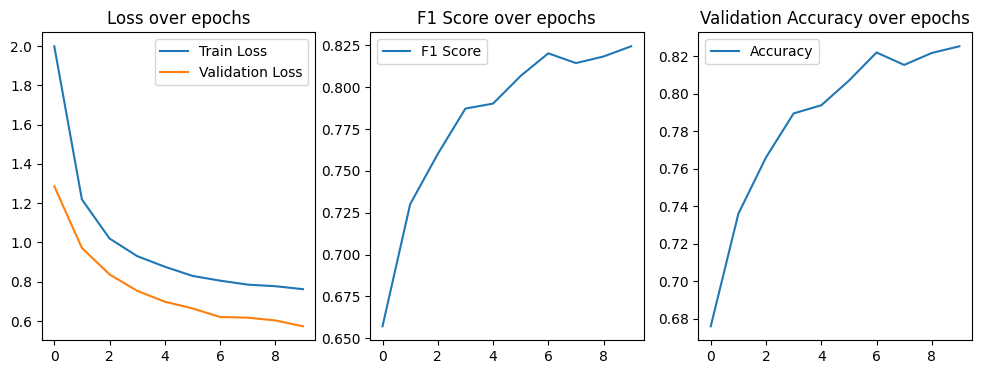

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 3, 2)
plt.plot(valid_f1s, label='F1 Score')
plt.legend()
plt.title('F1 Score over epochs')

plt.subplot(1, 3, 3)
plt.plot(valid_accuracies, label='Accuracy')
plt.legend()
plt.title('Validation Accuracy over epochs')
plt.show()
